# Descripción del Proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.
Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba.

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

## Descripción de los datos 

### Características 

* `RowNumber`: índice de cadena de datos

* `CustomerId`: identificador de cliente único

* `Surname`: apellido

* `CreditScore`: valor de crédito

* `Geography`: país de residencia

* `Gender`: sexo

* `Age`: edad

* `Tenure`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)

* `Balance`: saldo de la cuenta

* `NumOfProducts`: número de productos bancarios utilizados por el cliente

* `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)

* `IsActiveMember`: actividad del cliente (1 - sí; 0 - no)

* `EstimatedSalary`: salario estimado

### Objetivo

* `Exited`: El cliente se ha ido (1 - sí; 0 - no)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Observamos que la columna `tenure` tiene 909 datos faltantes. Esta es una de las características importantes para predecir la variable objetivo. Debemos decidir como manejar estos datos faltantes.

Con respecto a los tipos de datos no parece haber problemas!!!

# Preparando las características

### Datos faltantes en la columna `tenure`

In [5]:
data_filtered = data[~(data['tenure'].isna())]

In [6]:
data_filtered.corr()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1.000000,0.004289,0.002330,0.000681,-0.007322,-0.005921,0.009078,0.001248,0.009536,-0.004854,-0.014562
customerid,0.004289,1.000000,-0.001610,0.010379,-0.021418,-0.007445,0.014604,-0.019891,0.001499,0.010029,-0.007040
creditscore,0.002330,-0.001610,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
age,0.000681,0.010379,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.005921,-0.007445,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
numofproducts,0.009078,0.014604,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
hascrcard,0.001248,-0.019891,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
isactivemember,0.009536,0.001499,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
estimatedsalary,-0.004854,0.010029,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029


Si buscamos el coeficiente de correlación, vemos que la variable `tenure` tiene muy poca correlación con las otras variables cuantitativas. En ese sentido, no encontramos entre estas una relación que explique el comportamiento de la variable `tenure`. 

In [7]:
data_filtered['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

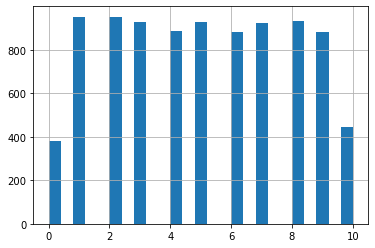

In [8]:
data_filtered['tenure'].hist(bins = 25)
plt.show()

La variable `tenure` toma solo valores enteros entre 0 y 10 años. Los datos se dividen en 10 grupos bien definidos casi todas con la misma frecuencia de ocurrencia, salvo los grupos extremos que son menos frecuentes.

In [9]:
data_filtered['gender'].value_counts(normalize = True)

Male      0.547135
Female    0.452865
Name: gender, dtype: float64

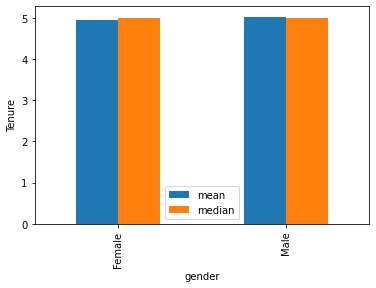

In [10]:
data_filtered.pivot_table(index = 'gender', values = 'tenure', aggfunc = ['mean', 'median']).plot(kind = 'bar')
plt.ylabel('Tenure')
plt.legend(['mean', 'median'])
plt.show()

Ambos grupos tienen valores muy similares de `media` y `mediana`.

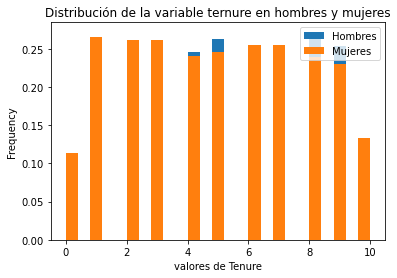

In [11]:
data_filtered[data_filtered['gender'] == 'Male']['tenure'].plot(kind = 'hist', bins = 25, density = True)
data_filtered[data_filtered['gender'] == 'Female']['tenure'].plot(kind = 'hist', bins = 25, density = True)
plt.legend(labels = ['Hombres', 'Mujeres'])
plt.xlabel('valores de Tenure')
plt.title('Distribución de la variable ternure en hombres y mujeres')
plt.show()

La distribución de la variable `tenure` es idéntica en ambos grupos.

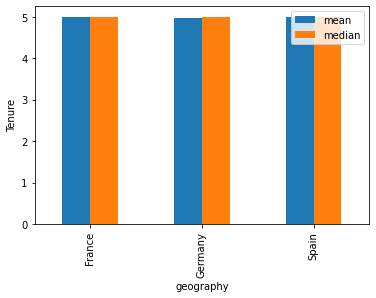

In [12]:
data_filtered.pivot_table(index = 'geography', values = 'tenure', aggfunc = ['mean', 'median']).plot(kind = 'bar', legend = False)
plt.ylabel('Tenure')
plt.legend(['mean', 'median'])
plt.show()

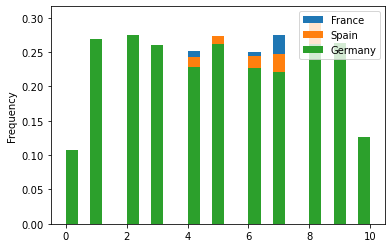

In [13]:
geography = data_filtered['geography'].unique()
for g in geography:
    data_filtered[data_filtered['geography'] == g]['tenure'].plot(kind = 'hist', bins = 25, density = True)
    plt.legend(labels = geography)

La distribución de la variable `tenure` es identica en los tres paises. 

**Conclusión:** No encontramos una relación clara entre la variable `tenure` y las otras variables del dataset, que pueda explicarnos los valores faltantes. En ese sentido, solo podemos proponer algunas hipótesis de por qué estos valores faltan. Una de ellas es que aquellos valores faltantes estan relacionado con usuarios que no tienen años de `tenure`. 

Dada la importancia que tiene esta variable proponemos no imputar estos valores con algún estimador, sino darle una valor que los ponga en una categoría diferente, podemos darle el valor -1. La idea de hacer esto viene de que la variable aunque tiene un tipo numérico se comporta como una variable categórica ordinal. En ese sentido, le estamos dando menos peso a los registros que no tienen valores en la variable `tenure`.

In [14]:
data['tenure'] = data['tenure'].fillna(-1)
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., -1.])

In [15]:
data['tenure'].isna().sum()

0

Hemos eliminado los valores ausentes en la columna `tenure`.

## Preparando las características para modelar.

En esta sección utilizaremos la codificación `One-Hot` para las variables categóricas. 

In [16]:
data_ohe = pd.get_dummies(data, columns = ['gender', 'geography'], drop_first = True)
data_ohe.shape

(10000, 15)

In [17]:
data_ohe.head()

,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male,geography_Germany,geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Hemos utilizado la codificación `One-Hot` para las variables categóricas `gender` y `geography`.

In [18]:
features = data_ohe.drop(['rownumber', 'customerid', 'surname', 'exited'], axis = 1)
target = data_ohe['exited']

Vamos a creas los conjuntos de `entrenamiento`, `validación` y `prueba` en una proporción `3:1:1`.

In [19]:
features_train, features_vt, target_train, target_vt = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt, target_vt, test_size = 0.5, random_state = 12345)

Hemos construidos los conjunto de `entrenamiento`,`validez` y `prueba`. 

In [20]:
numeric_var = ['creditscore', 'balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric_var])

StandardScaler()

In [21]:
features_train[numeric_var] = scaler.transform(features_train[numeric_var])
features_valid[numeric_var] = scaler.transform(features_valid[numeric_var])
features_test[numeric_var] = scaler.transform(features_test[numeric_var])

Hemos codificado y escalado las variables correspondientes.

# Explorando varias opciones de modelos de clasificación. 

En este sesión, vamos a explorar el desequilibrio de las clases y vamos a entrenar diferentes modelos sin considerar el desequilibrio de clases.

In [22]:
target_train.value_counts(normalize = True)

0    0.800667
1    0.199333
Name: exited, dtype: float64

Se observa un marcado desequilibrio de clases. La clase positiva es mucho menos frecuente.

### Modelo logístico de clasificación

In [23]:
model_log = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_log.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

In [24]:
predictions_train = model_log.predict(features_train)
accu_train = accuracy_score(target_train, predictions_train)
print(f'La exactitud del modelo para los datos de entrenamiento es {accu_train}')

La exactitud del modelo para los datos de entrenamiento es 0.8191666666666667


In [26]:
predictions_valid = model_log.predict(features_valid)
accu_valid = accuracy_score(target_valid, predictions_valid)
print(f'La exactitud del modelo para los datos de validación es {accu_valid}')

La exactitud del modelo para los datos de validación es 0.802


Observamos un ligero sobreajuste del modelo y una exactitud para los datos de validación de poco más del 80%.

In [27]:
recall_valid = recall_score(target_valid, predictions_valid)
print(f'El recall del modelo para los datos de validación es {recall_valid}')

El recall del modelo para los datos de validación es 0.23205741626794257


In [28]:
precision_valid = precision_score(target_valid, predictions_valid)
print(f'La precisión del modelo para los datos de validación es {precision_valid}')

La precisión del modelo para los datos de validación es 0.563953488372093


In [29]:
f1_valid = f1_score(target_valid, predictions_valid)
print(f'El f1 del modelo para los datos de validación es {f1_valid}')

El f1 del modelo para los datos de validación es 0.3288135593220339


El modelo muestra ser más que preciso que eficiente para encontrar las respuestas verdaderas positivas. En otras palabras el modelo solo va encontrar al `23%` porciento de los clientes que se van, pero será preciso en más del `50%` cuando marque a un cliente positivo a la salida. Observamos un `F1` de 0.33.

### Modelo de árbol de decisión

In [30]:
model_tree = None
good_depth = 0
accu = 0

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accu_temp = accuracy_score(target_valid, predictions)
    if accu_temp > accu:
        accu = accu_temp
        good_depth = depth
        model_tree = model
print(f'La precisión optima del modelo se obtiene a una profundida de {good_depth}, siendo {accu}')

La precisión optima del modelo se obtiene a una profundida de 6, siendo 0.858


In [31]:
predictions_valid = model_tree.predict(features_valid)
accu_valid = accuracy_score(target_valid, predictions_valid)
print(f'La exactitud del modelo para los datos de validación es {accu_valid}')

La exactitud del modelo para los datos de validación es 0.858


In [32]:
recall_valid = recall_score(target_valid, predictions_valid)
print(f'El recall del modelo para los datos de validación es {recall_valid}')

El recall del modelo para los datos de validación es 0.44976076555023925


In [33]:
precision_valid = precision_score(target_valid, predictions_valid)
print(f'La precisión del modelo para los datos de validación es {precision_valid}')

La precisión del modelo para los datos de validación es 0.7768595041322314


In [34]:
f1_valid = f1_score(target_valid, predictions_valid)
print(f'El f1 del modelo para los datos de validación es {f1_valid}')

El f1 del modelo para los datos de validación es 0.5696969696969697


El `árbol de decisión` entrenado mejora en mucho todas las métricas del modelo de `regresión logística`, tiene mejor `recall`, `precisión` y `F1`.

### Modelo de bosque aleatorio

In [35]:
model_forest = None
good_depth = 0
good_estimators = 0
accu = 0
for n in range(10,50,10):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 12345, max_depth = depth, n_estimators = n)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accu_temp = accuracy_score(target_valid, predictions)
        if accu_temp > accu:
            accu = accu_temp
            good_depth = depth
            model_forest = model
            good_estimators = n
print(f'El modelo más exacto tiene profundidad {good_depth}, cantidad de árboles {good_estimators} y exactitud {accu}')

El modelo más exacto tiene profundidad 8, cantidad de árboles 20 y exactitud 0.865


In [36]:
predictions_valid = model_forest.predict(features_valid)
accu_valid = accuracy_score(target_valid, predictions_valid)
print(f'La exactitud del modelo para los datos de validación es {accu_valid}')

La exactitud del modelo para los datos de validación es 0.865


In [37]:
recall_valid = recall_score(target_valid, predictions_valid)
print(f'El recall del modelo para los datos de validación es {recall_valid}')

El recall del modelo para los datos de validación es 0.43779904306220097


In [38]:
precision_valid = precision_score(target_valid, predictions_valid)
print(f'La precisión del modelo para los datos de validación es {precision_valid}')

La precisión del modelo para los datos de validación es 0.8394495412844036


In [39]:
f1_valid = f1_score(target_valid, predictions_valid)
print(f'El f1 del modelo para los datos de validación es {f1_valid}')

El f1 del modelo para los datos de validación es 0.5754716981132075


El modelo de `bosque aleatorio` con los hiperparámetros `n_estimators = 20` y `max_depth = 8` encontrado mejora todas las métricas de los dos anteriores. 

### Prueba de cordura

In [40]:
predictions_test = model_forest.predict(features_test)
accuracy_score(target_test, predictions_test)

0.839

In [41]:
predictions_const = pd.Series(data = 0, index = target_test.index)
accuracy_score(target_test, predictions_const)

0.7885

El modelo pasa la prueba de cordura: la exactitud de los datos de prueba es más alta que la del modelo constante.

## Estrategias para manejar el desequilibrio de clases. 

Trataremos de mejorar las métricas del modelo aplicando técnicas para manejar el desequilibrio de clases. 

### Ajuste de peso de clase

In [43]:
model_forest_balanced = RandomForestClassifier(random_state = 12345, max_depth = 8, n_estimators = 20, class_weight = 'balanced')
model_forest_balanced.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=20,
                       random_state=12345)

In [44]:
predictions_test = model_forest_balanced.predict(features_test)
accuracy_score(target_test, predictions_test)

0.8165

In [45]:
predictions_test = model_forest.predict(features_test)
accuracy_score(target_test, predictions_test)

0.839

El modelo de `bosque aleatorio` con peso de clase balanceado no mejora la métrica de exactitud.

In [46]:
model_log_balanced = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')

In [47]:
model_log_balanced.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

In [49]:
predictions_test = model_log_balanced.predict(features_test)
accuracy_score(target_test, predictions_test)

0.698

In [50]:
predictions_test = model_log.predict(features_test)
accuracy_score(target_test, predictions_test)

0.793

La estrategia de ajuste de peso de clase no ha sido efectiva para mejorar la métrica del modelo. 

### Sobremuestreo

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

Hemos creado una función que repite un número dado de veces la cantidad de respuestas raras y despúes las baraja aleatoriamente.

In [52]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [53]:
model_forest = RandomForestClassifier(random_state = 12345, max_depth = 8, n_estimators = 20)
model_forest.fit(features_upsampled, target_upsampled)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=12345)

In [54]:
predictions_test = model_forest.predict(features_test)
accuracy_score(target_test, predictions_test)

0.672

La técnica de sobremuestro no mejora la métrica de exactitud!!

### Submuestreo

In [55]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [56]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [62]:
model_forest = RandomForestClassifier(random_state = 12345, max_depth = 8, n_estimators = 20)
model_forest.fit(features_downsampled, target_downsampled)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=12345)

In [63]:
predictions_test = model_forest.predict(features_test)
accuracy_score(target_test, predictions_test)

0.5545

**Conclusiones:** Hemos experimentado con tres técnicas para tratar el desbalance de clases y ninguna ofreció mejor exactitud que el modelo de RandomForest entrenado sin tratamiento del desbalance. Esto se puede explicar con el siguiente análisis.

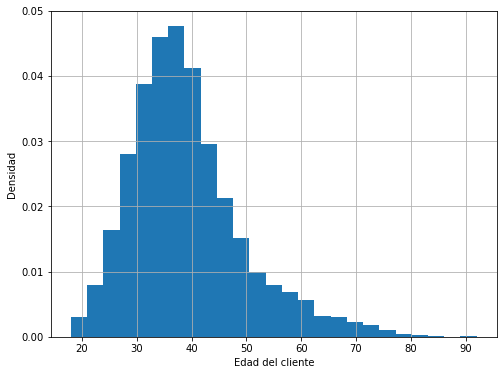

In [59]:
data['age'].hist(bins = 25, density = True, figsize = (8,6))
plt.xlabel('Edad del cliente')
plt.ylabel('Densidad')
plt.show()

La mayoría de los clientes son personas jóvenes entre 30 y 40 años. 

In [60]:
def grouped_age(row):
    if 18 <= row['age'] <= 30:
        return '18-30'
    elif 30 < row['age'] <= 40:
        return '31-40'
    elif 40 < row['age'] <= 70: 
        return '41-70'
    else: 
        '+70'
data['grouped_age'] = data.apply(grouped_age, axis = 1)

In [61]:
pd.crosstab(data['grouped_age'], data['exited'], normalize = True)

exited,0,1
grouped_age,,
18-30,0.184453,0.014999
31-40,0.396574,0.054525
41-70,0.213641,0.135806


El `58%` de los que se fieles al banco son personas jóvenes, que son la mayoría de los clientes del banco. Entonces, existe al menos una característica, en este caso la `edad` que explica el desbalance de clases. Debido a lo anterior, el modelo es capaz de identificar el desbalance y aprender de los datos considerando este desbalance. Si aplicamos técnicas de submuestreo o sobremuestreo, confundimos al modelo. 

## Curvas PR y ROC 

Vamos a observar como se comportan las curvas PR y ROC para el modelo logistico. 

In [65]:
model_log = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_log.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

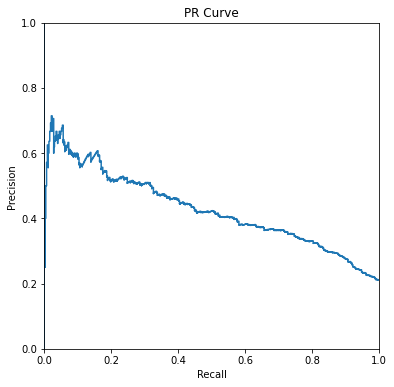

In [66]:
probabilities_test = model_log.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('PR Curve')
plt.show()

Obtenemos una curva PR con un valor mínimo de `precisión` de más 0.2 y un máximo cercano 0.7. 

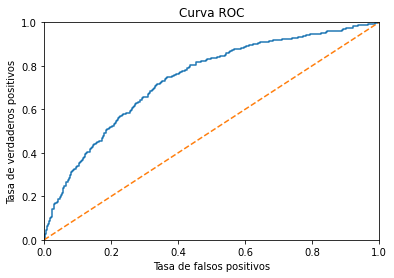

In [67]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1]) 
plt.ylim([0,1]) 
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos') 
plt.title('Curva ROC')
plt.show()

In [68]:
roc_auc_score(target_test, probabilities_test[:, 1])

0.7384461324206869

Obtenemos un valor de la métrica `roc_auc_score` de `0.74` para el modelo de `LogisticRegression`.

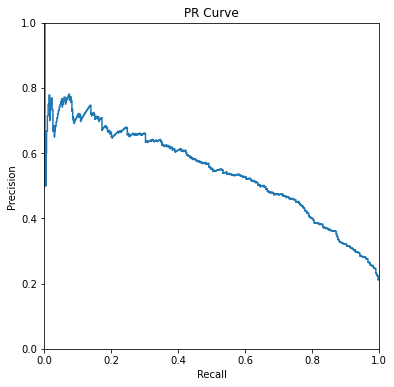

In [69]:
probabilities_test = model_forest.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('PR Curve')
plt.show()

Para el modelo de `RandomForestClassifier` obtenemos una curva `PR` con un mínimo de poco más de 0.2 y valores cercanos a 1 pero con valores muy pequeños de Recall. 

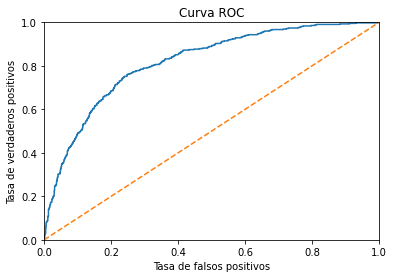

In [70]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1]) 
plt.ylim([0,1]) 
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos') 
plt.title('Curva ROC')
plt.show()

In [71]:
roc_auc_score(target_test, probabilities_test[:, 1])

0.817628108552163

Para el modelo `RandomForestClassifier` obtemos una métrica `roc_auc_score` 0.82, mejorando la del modelo `LogisticRegression`.

## Conclusiones finales

Después de preparar los datos adecuadamente utilizando la codificación `One-Hot` para las características categóricas y escalamiento para las características numéricas, hemos experimentado con varios tipos de modelos de clasificación, variando los hiperparámetros para obtimizar la métrica de exactitud y aplicando técnicas para el desbalance de clases que encontramos. Obtuvimos las siguientes conclusiones:

* El modelo `RandomForestClassifier` con hiperparámetros `n_estimators = 20` y `max_depth = 8` muestra mejores métricas. 

* Las técnicas para manejar el balace de clases de no mejoran las métricas. Esto se debe a que las características explican el desbalance de clases y esto lo identifica el modelo. 

* La métrica `roc_auc_score` también es más alta para el model `RandomForestClassifier`. Con los hiperparámetros antes mencionados. 